Install these if necessary.

In [1]:
# %pip install umap-learn --quiet

Load necessary libraries.

In [2]:
## Basics
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## ML Packages
import umap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import SpectralEmbedding, TSNE

## Msc
from adjustText import adjust_text
from itertools import combinations

Load dataset.

In [3]:
df = pd.read_csv('00_authors.csv').rename(columns = {'Unnamed: 0': 'Author'}).drop(columns = 'BookID')
X = df.copy().drop(['Author'], axis=1)

# Spectral Embeddings

In [4]:
authors = df['Author'].values
# Spectral Embedding
spectral = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=10)
X_spec = spectral.fit_transform(X)  # shape: (n_samples, 2)

In [5]:
spectral_df = pd.DataFrame(X_spec, columns=['Dim1', 'Dim2'])
spectral_df

,Dim1,Dim2
0,-0.007111,-0.008917
1,-0.006892,-0.008333
2,-0.005685,-0.011816
3,-0.007001,-0.006907
4,-0.006686,-0.007141
...,...,...
836,0.013412,-0.009280
837,0.013539,-0.008909
838,0.013516,-0.009077
839,0.013625,-0.008827


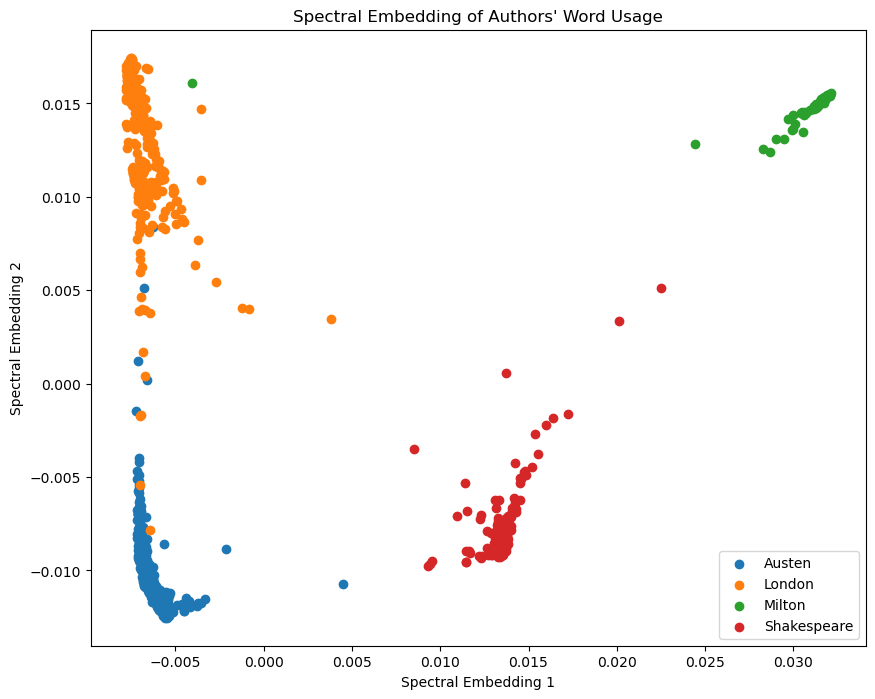

In [6]:
plt.figure(figsize=(10, 8))
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    plt.scatter(X_spec[mask, 0], X_spec[mask, 1], label=author)
plt.xlabel("Spectral Embedding 1")
plt.ylabel("Spectral Embedding 2")
plt.title("Spectral Embedding of Authors' Word Usage")
plt.legend(loc="lower right")
plt.show()


Unlike PCA and NMF there are no components we can use to visualize the features in Spectral Embedding.  However, we can apply a transpose to our data and then reapply Spectral Embedding.

This procedure will yield results where:

- Two words will be close in the embedding if they tend to appear in the same chapters.

- This gives you a co-occurrence-like structure, driven by chapter usage.

- This is conceptually similar to Latent Semantic Analysis, just via graph-based distance instead of SVD.

In [7]:
X_transpose = X.T
X_transpose = X_transpose.rename(columns = {i:f'Chapter{i}' for i in range(df.shape[0])})
X_transpose

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
a,46,35,46,40,29,27,34,38,34,54,...,46,48,39,22,28,32,16,22,25,26
all,12,10,2,7,5,8,8,6,12,8,...,4,2,5,13,7,4,5,15,4,4
also,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
an,3,7,3,4,6,3,15,2,5,6,...,3,9,10,5,7,6,5,3,8,2
and,66,44,40,64,52,42,44,67,50,44,...,43,45,38,47,45,33,49,48,59,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,8,3,4,5,2,6,4,6,1,3,...,1,0,2,4,2,3,0,0,2,3
will,4,5,5,3,4,3,9,7,2,5,...,7,10,8,9,7,11,11,12,22,11
with,9,14,15,22,21,18,11,15,13,15,...,18,11,26,12,8,17,20,15,23,19
would,1,8,3,4,10,4,6,3,12,6,...,2,6,2,6,3,5,2,1,4,0


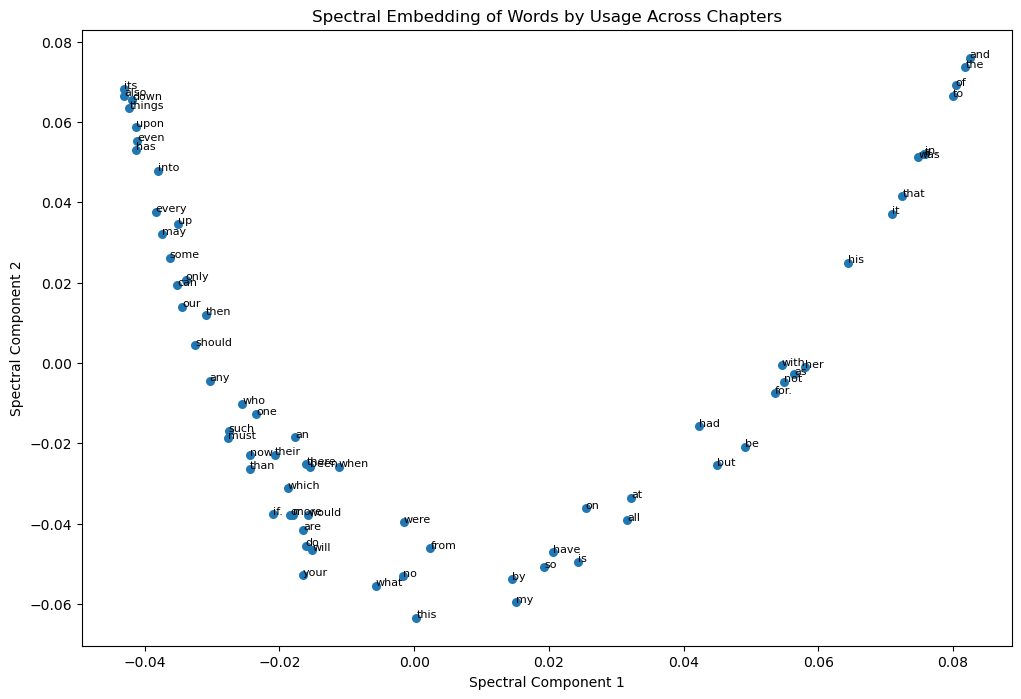

In [8]:
X_words = X_transpose.to_numpy()
spectral = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=10, random_state=0)
X_words_spec = spectral.fit_transform(X_words)

plt.figure(figsize=(12, 8))
plt.scatter(X_words_spec[:, 0], X_words_spec[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    plt.text(X_words_spec[i, 0], X_words_spec[i, 1], word, fontsize=8)
plt.title("Spectral Embedding of Words by Usage Across Chapters")
plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.show()


# UMAP

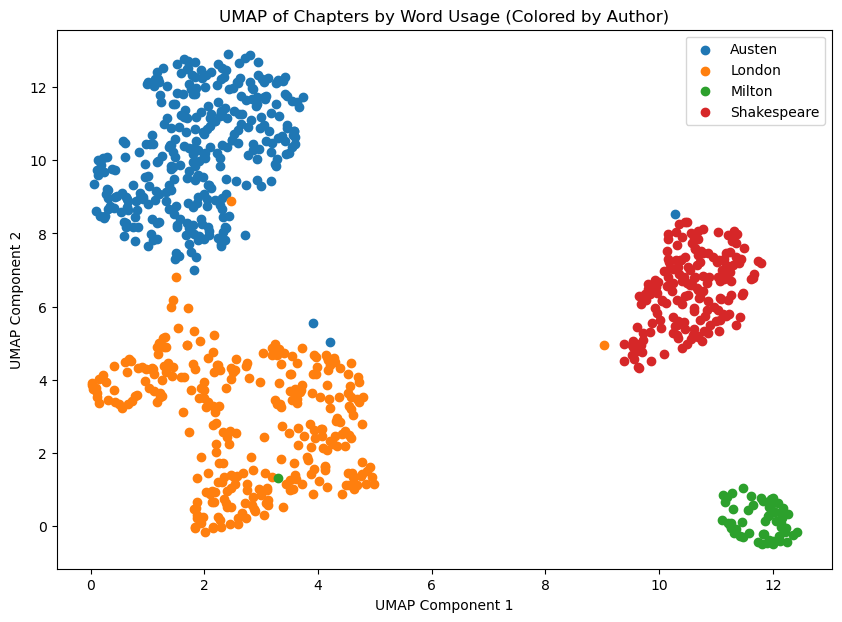

In [9]:
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, n_jobs=-1) # Fit UMAP
X_umap = umap_model.fit_transform(X.to_numpy())

plt.figure(figsize=(10, 7))
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=author)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP of Chapters by Word Usage (Colored by Author)")
plt.legend(loc="upper right")
plt.show()


UMAP does a very good job at creating seperable clusters! This visualization appears to be the best so far when observing observations (chapters)!

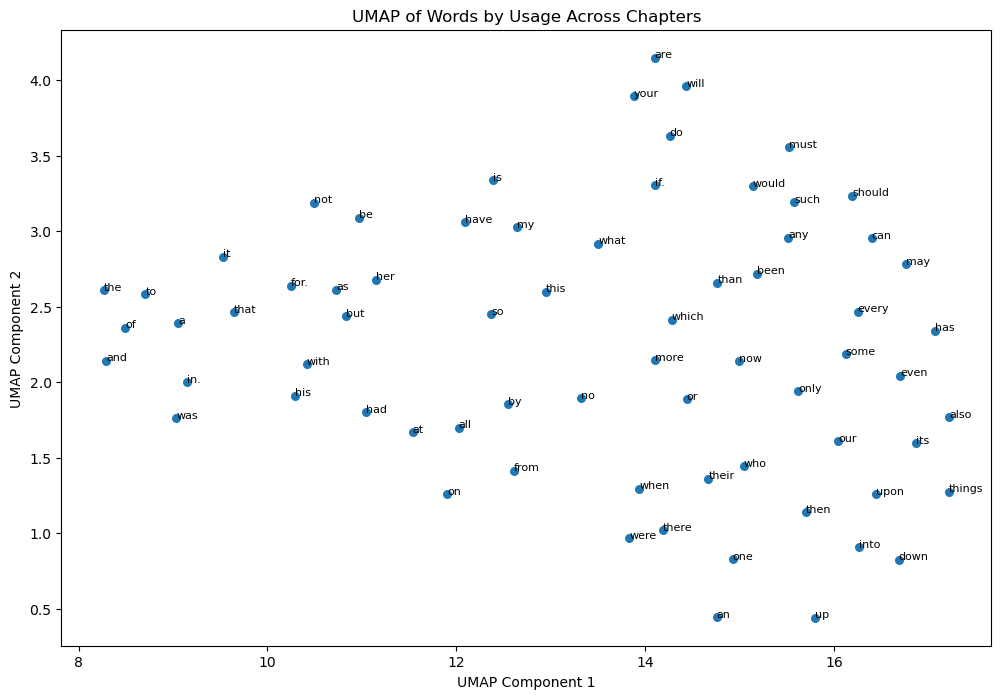

In [10]:
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, n_jobs=-1) # Fit UMAP
X_words_umap = umap_model.fit_transform(X_transpose.to_numpy())

# Plot w/ word labels
plt.figure(figsize=(12, 8))
plt.scatter(X_words_umap[:, 0], X_words_umap[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    plt.text(X_words_umap[i, 0], X_words_umap[i, 1], word, fontsize=8)
plt.title("UMAP of Words by Usage Across Chapters")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


Not very interpretable/helpful.

# tSNE

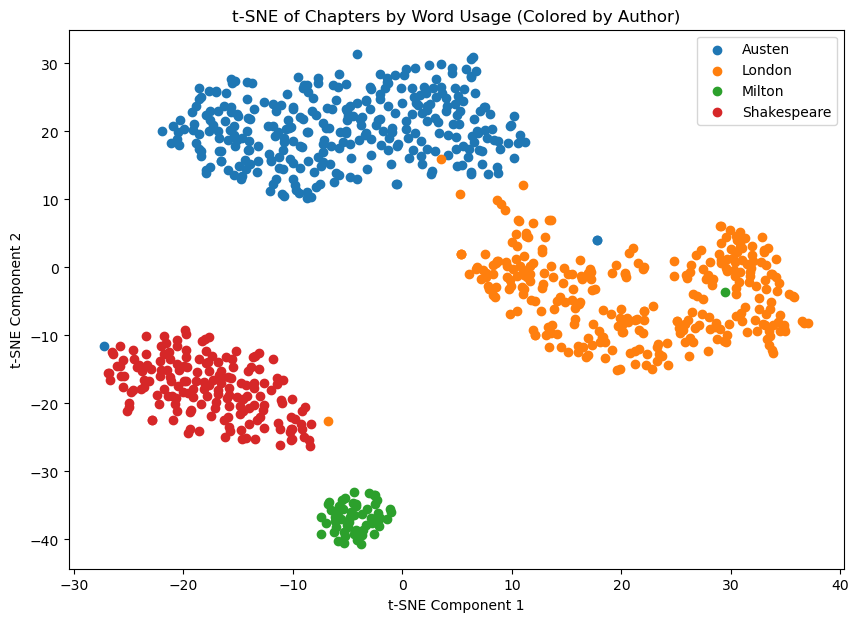

In [11]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto') # Fit t-SNE
X_tsne = tsne.fit_transform(X.to_numpy())

# Plot chapters with author labels
plt.figure(figsize=(10, 7))
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=author)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE of Chapters by Word Usage (Colored by Author)")
plt.legend(loc="upper right")
plt.show()


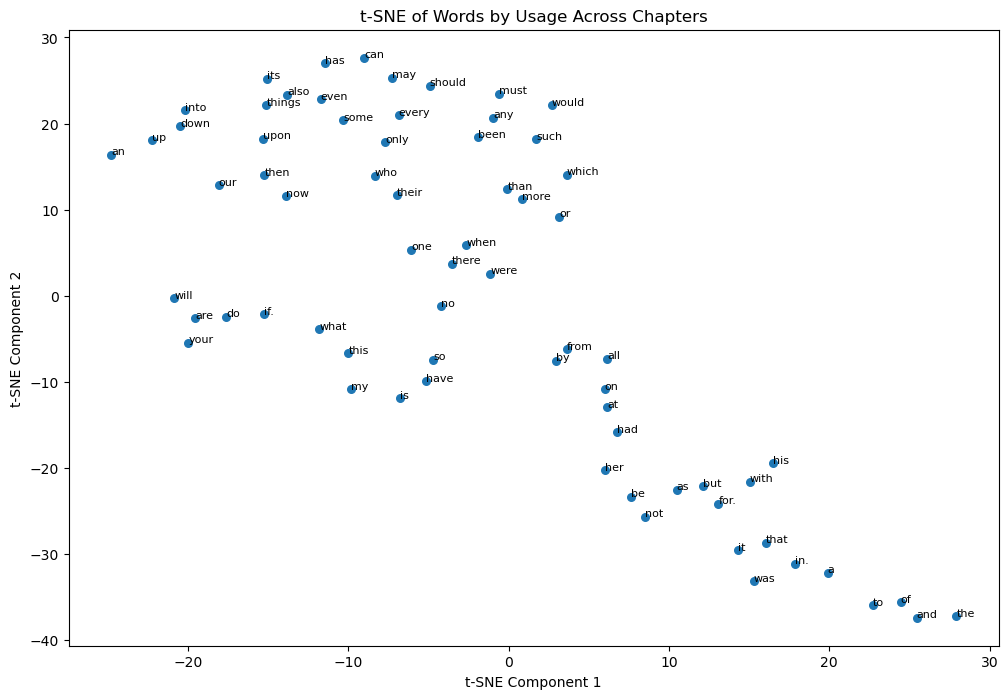

In [12]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate='auto') # Fit t-SNE
X_words_tsne = tsne.fit_transform(X_words)

# Plot w/ word labels
plt.figure(figsize=(12, 8))
plt.scatter(X_words_tsne[:, 0], X_words_tsne[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    plt.text(X_words_tsne[i, 0], X_words_tsne[i, 1], word, fontsize=8)

plt.title("t-SNE of Words by Usage Across Chapters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


# Combined Visualizations

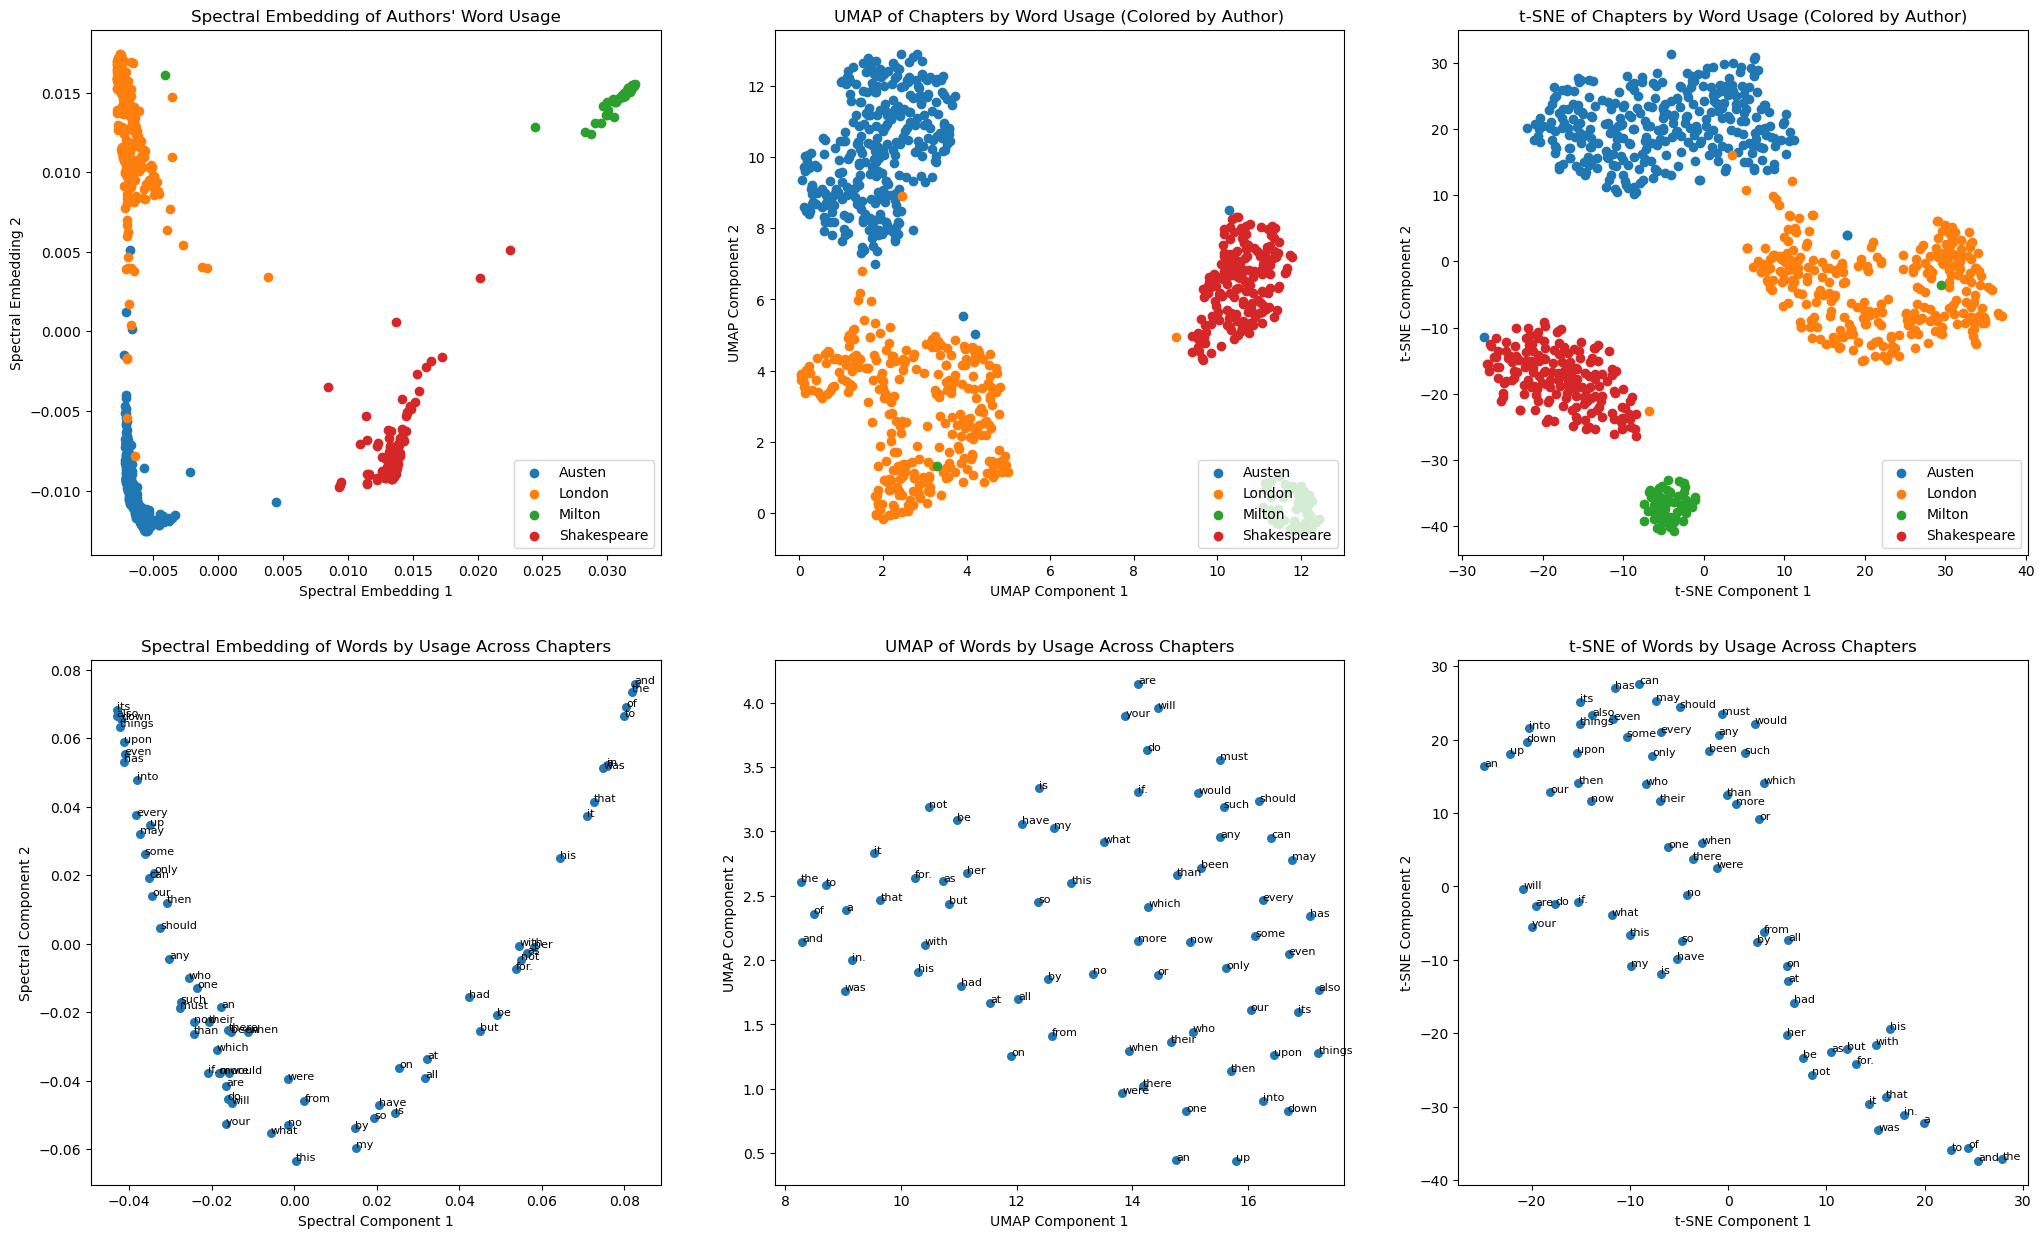

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15), sharey=False)  # 1 row, 3 columns

# Spectral Embedding
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    ax[0,0].scatter(X_spec[mask, 0], X_spec[mask, 1], label=author)
ax[0,0].set_xlabel("Spectral Embedding 1")
ax[0,0].set_ylabel("Spectral Embedding 2")
ax[0,0].set_title("Spectral Embedding of Authors' Word Usage")
ax[0,0].legend(loc="lower right")

ax[1,0].scatter(X_words_spec[:, 0], X_words_spec[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    ax[1,0].text(X_words_spec[i, 0], X_words_spec[i, 1], word, fontsize=8)
ax[1,0].set_title("Spectral Embedding of Words by Usage Across Chapters")
ax[1,0].set_xlabel("Spectral Component 1")
ax[1,0].set_ylabel("Spectral Component 2")

# UMAP
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    ax[0,1].scatter(X_umap[mask, 0], X_umap[mask, 1], label=author)
ax[0,1].set_xlabel("UMAP Component 1")
ax[0,1].set_ylabel("UMAP Component 2")
ax[0,1].set_title("UMAP of Chapters by Word Usage (Colored by Author)")
ax[0,1].legend(loc="lower right")

ax[1,1].scatter(X_words_umap[:, 0], X_words_umap[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    ax[1,1].text(X_words_umap[i, 0], X_words_umap[i, 1], word, fontsize=8)
ax[1,1].set_title("UMAP of Words by Usage Across Chapters")
ax[1,1].set_xlabel("UMAP Component 1")
ax[1,1].set_ylabel("UMAP Component 2")

# tSNE
for author in ['Austen', 'London', 'Milton', 'Shakespeare']:
    mask = (authors == author)
    ax[0,2].scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=author)
ax[0,2].set_xlabel("t-SNE Component 1")
ax[0,2].set_ylabel("t-SNE Component 2")
ax[0,2].set_title("t-SNE of Chapters by Word Usage (Colored by Author)")
ax[0,2].legend(loc="lower right")

ax[1,2].scatter(X_words_tsne[:, 0], X_words_tsne[:, 1], s=30)
for i, word in enumerate(X_transpose.index):
    ax[1,2].text(X_words_tsne[i, 0], X_words_tsne[i, 1], word, fontsize=8)
ax[1,2].set_title("t-SNE of Words by Usage Across Chapters")
ax[1,2].set_xlabel("t-SNE Component 1")
ax[1,2].set_ylabel("t-SNE Component 2")

plt.savefig('Media/02_nonlinear_viz')
plt.show()

UMAP offers the best balance between global and local structure, preserves neighborhood quality, and gives interpretable groupings without as much distortion as t-SNE.

Clusters of words in the UMAP embedding reflect similar usage patterns across chapters.
Since word usage is shaped by topic and syntax, these local neighborhoods can be interpreted as reflecting semantic or grammatical similarity.
While UMAP does not preserve global distances, local groupings are meaningful.